# Import statements

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# Graph Class
Same as for k_redundant_trees.ipynb

In [22]:
class Graph:
    '''This is a class only used to define the undirected Graphs. These Graphs are then used to create the kNTs.'''
    def __init__(self, adjacency_list):
        self.adjacency_list = {str(key): [str(v) for v in value] for key, value in adjacency_list.items()}

    def two_direction_adj_list(self):
        '''Ensure that the graph is undirected.'''
        # Create a new dictionary to store the modified adjacency list
        modified_adjacency_list = {}

        # Iterate through the keys and values of the initial adjacency list
        for node, neighbors in self.adjacency_list.items():
            modified_adjacency_list[node] = neighbors
            # Add reverse edges for each edge
            for neighbor in neighbors:
                if neighbor not in modified_adjacency_list:
                    modified_adjacency_list[neighbor] = []
                if node not in modified_adjacency_list[neighbor]:  # Ensure no duplicate edges
                    modified_adjacency_list[neighbor].append(node)
        
        return modified_adjacency_list

    def get_neighbors(self, v):
        '''Return neighbors of a given node.'''
        outgoing_neighbors = self.adjacency_list.get(v, [])
        incoming_neighbors = [node for node, neighbors in self.adjacency_list.items() if v in neighbors]
        return list(set(outgoing_neighbors + incoming_neighbors))  # Combine and remove duplicates

    def find_longest_path(self):
        return 999999999
        # '''Use depth-first search to find the longest path in a graph.'''
        # def dfs(node, visited, path):
        #     visited.add(node)
        #     path.append(node)
        #     longest = path[:]
        #     for neighbor in self.get_neighbors(node):
        #         if neighbor not in visited:
        #             current_path = dfs(neighbor, visited, path)
        #             if len(current_path) > len(longest):
        #                 longest = current_path
        #     path.pop()
        #     visited.remove(node)
        #     return longest

        # longest_path = []
        # for start_node in self.adjacency_list:
        #     visited = set()
        #     path = []
        #     current_path = dfs(start_node, visited, path)
        #     if len(current_path) > len(longest_path):
        #         longest_path = current_path

        # return longest_path

# Truncated ePath Tree Class

In [23]:
class TPT:
    def __init__(self, G, root, max_depth=None, iteration_limit=100000):
        self.G = G
        self.root = str(root)
        # In the testing I don't actually use the max_depth like this because DFS is complex and we can logically restrict easily
        if max_depth is None:
            self.max_depth = G.find_longest_path() + 1  # Set max_depth based on longest path
        else:
            self.max_depth = max_depth
        self.tpt_tree = nx.DiGraph()
        self.node_labels = {}
        self.nodes = set()
        self.iteration_limit = iteration_limit
        self.build_tree(self.root)  # Use modified BFS to add paths

    def get_root(self):
        '''Return the root of the tree.'''
        return self.root

    def add_node_to_tree(self, node_id, node_name, label):
        '''Helper function to add a node to the tree.'''
        self.tpt_tree.add_node(node_id, label=label)
        self.node_labels[node_id] = {'label': label, 'name': node_name}
        self.nodes.add(node_id)
        # print(f"Adding node: {node_id}")

    def add_edge_to_tree(self, parent_id, current_id):
        '''Helper function to add an edge to the tree.'''
        self.tpt_tree.add_edge(parent_id, current_id)
        # print(f"Adding edge from {parent_id} to {current_id}")

    def build_tree(self, start_node):
        '''Main function used to create the tree using mostly BFS logic.
        Instead of nodes just being visited/not visited, we also must check for the special condition
        of the TPT that the node can have already been visited if it is the root.'''
        # Enqueue the start node until its vertices are visited
        queue = [(start_node, [start_node])]
        iteration_count = 0  # To keep track of the number of iterations

        # Continue as long as there is a queue
        while queue:
            current_node, path = queue.pop(0)
            depth = len(path) - 1

            node_id = "-".join(path)
            node_name = node_id.split('-')[-1]

            # If the depth is 0 then we are at the root so we just add it
            if depth == 0:
                self.add_node_to_tree(node_id, node_name, self.root)
            # Otherwise we need to consider the parent when giving the node a unique name for the tree
            else:
                parent_id = "-".join(path[:-1])
                self.add_node_to_tree(node_id, node_name, current_node)
                self.add_edge_to_tree(parent_id, node_id)

            # We should never reach this condition for our testing, but it is here in case we intentionally set a lower value
            if depth >= self.max_depth:
                continue

            # Go through all the neighbors of the current step
            for neighbor in self.G.get_neighbors(current_node):
                neighbor = str(neighbor)

                # This is the only case where we can have a repeat node
                # It has to be the root and the path length has to be greater than 2
                if neighbor == start_node and len(path) > 2:
                    # new_node_id = "-".join(new_path)
                    new_node_id = f"{node_id}-{neighbor}"
                    new_node_name = new_node_id.split('-')[-1]
                    self.add_node_to_tree(new_node_id, new_node_name, current_node)
                    self.add_edge_to_tree(node_id, new_node_id)
                    break  # Stop further exploration from this path

                # If we haven't seen the node before, queue it for the BFS
                if neighbor not in path:
                    new_path = path + [neighbor]
                    queue.append((neighbor, new_path))

            iteration_count += 1
            if iteration_count > self.iteration_limit:
                print("iteration limit reached")
                break

    def print_tree(self):
        '''Print the tree as text.'''
        print("Tree Structure:")
        for parent, children in self.tpt_tree.adjacency():
            print(f"Parent: {self.node_labels[parent]['name']}")
            if children:
                child_names = [self.node_labels[child]['name'] for child in children]
                print(f"Children: {child_names}")
            else:
                print("No Children")
            print("-" * 20)

    def plot_tree(self):
        '''Plot the tree on its own plot.'''
        fig, ax = plt.subplots(figsize=(9, 3))
        pos = nx.drawing.nx_agraph.graphviz_layout(self.tpt_tree, prog='dot')
        node_labels = {node: self.node_labels[node]['name'] for node in self.tpt_tree.nodes()}
        nx.draw(self.tpt_tree, pos, ax=ax, labels=node_labels, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
        ax.set_title(f'TPT from Root: {self.root}')
        plt.show()

    def plot_tree_with_ax(self, ax):
        '''Plot the tree given an axis (intended for use as subplot in plots).'''
        pos = nx.drawing.nx_agraph.graphviz_layout(self.tpt_tree, prog='dot')
        node_labels = {node: self.node_labels[node]['name'] for node in self.tpt_tree.nodes()}
        nx.draw(self.tpt_tree, pos, ax=ax, labels=node_labels, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
        ax.set_title(f'TPT from Root: {self.root}')

    def chi(self, node):
        '''Return children of a given node.'''
        return list(self.tpt_tree.successors(node))


# Checking for accuracy on given example
Example from: https://proceedings.neurips.cc/paper_files/paper/2022/file/1bd6f17639876b4856026744932ec76f-Paper-Conference.pdf

<img src="tpt_example.png" width="600px">


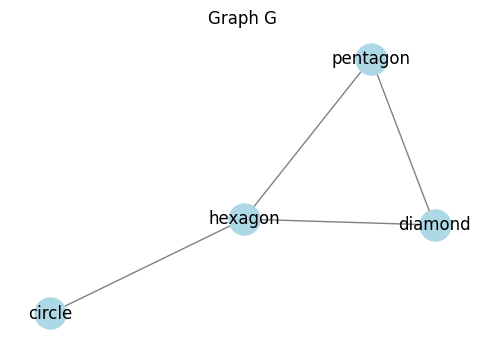

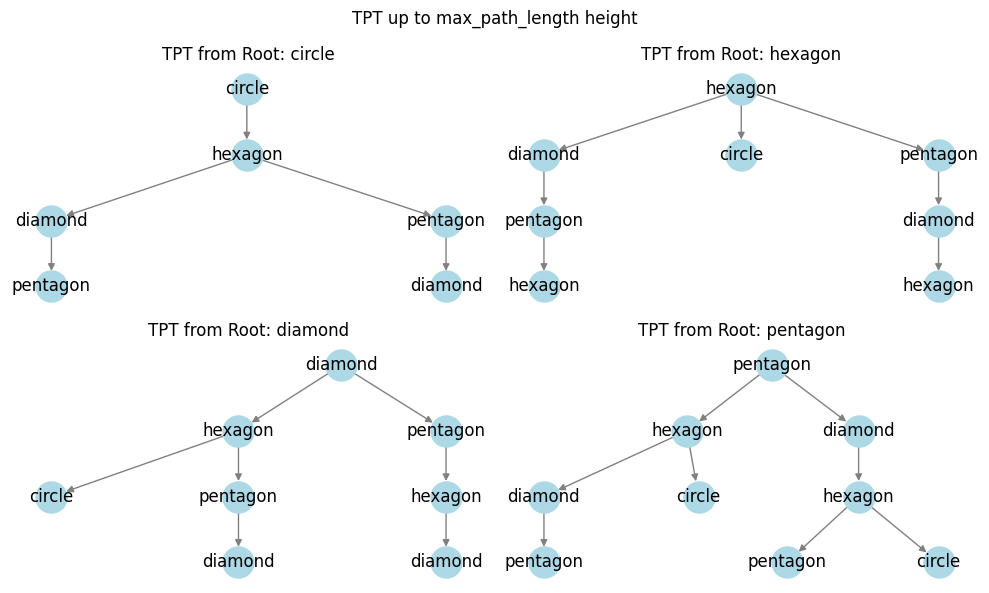

In [24]:
# Create an instance of the Graph class with the provided adjacency list
adjacency_list = {
    'circle': ['hexagon'],
    'hexagon': ['circle', 'pentagon', 'diamond'],
    'pentagon': ['hexagon', 'diamond'],
    'diamond': ['hexagon', 'pentagon']
}
possible_roots = ['circle', 'hexagon', 'diamond', 'pentagon']

G = Graph(adjacency_list)
G.adjacency_list = G.two_direction_adj_list()

# Plotting the graph G
fig, ax = plt.subplots(figsize=(6, 4))
G_nx = nx.Graph(G.adjacency_list)
nx.draw(G_nx, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, ax=ax)
ax.set_title("Graph G")
plt.show()


# Plotting the TPT
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
max_height = 8
fig.suptitle(f'TPT up to max_path_length height')


for i in range(2):
    for j in range(2):
        root = possible_roots[i * 2 + j]
        tpt = TPT(G, root, max_height)
        tpt.plot_tree_with_ax(ax[i,j])
        # create_tpt(G, root, max_height, ax[i,j])

plt.tight_layout()
plt.show()


# Testing on other types of graphs

## Repeated Node Labels

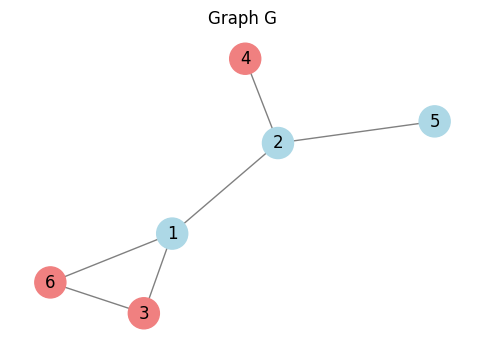

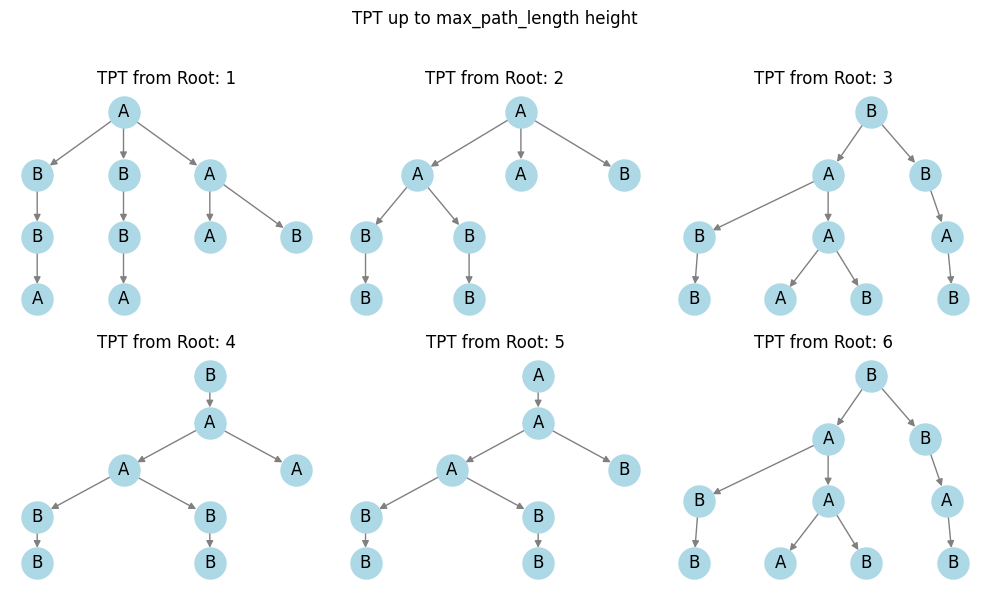

In [25]:
# Random adjacency list
adjacency_list = {
    '1': ['2', '3', '6'],
    '2': ['1', '4', '5'],
    '3': ['1', '6'],
    '4': ['2'],
    '5': ['2'],
    '6': ['3']
}

# Repeated node labels: A or B
node_labels = {
    '1': 'A',
    '2': 'A',
    '3': 'B',
    '4': 'B',
    '5': 'A',
    '6': 'B'
}

possible_roots = ['1', '2', '3', '4', '5', '6']

G = Graph(adjacency_list)
G.adjacency_list = G.two_direction_adj_list()

# Give different colors to the different labels so we visually check the TPTs
node_colors = ['lightblue' if node_labels[node] == 'A' else 'lightcoral' for node in G.adjacency_list]

# Plotting the graph G
fig, ax = plt.subplots(figsize=(6, 4))
G_nx = nx.Graph(G.adjacency_list)
nx.draw(G_nx, with_labels=True, node_color=node_colors, edge_color='gray', node_size=500, ax=ax)
ax.set_title("Graph G")
plt.show()

# Plotting the TPT
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
# max_height = 4
fig.suptitle(f'TPT up to max_path_length height')

for idx, root in enumerate(possible_roots):
    i, j = divmod(idx, 3)
    tpt = TPT(G, root)
    for node in tpt.tpt_tree.nodes():
        tpt.node_labels[node]['name'] = node_labels[node.split('-')[-1]]
    tpt.plot_tree_with_ax(axes[i, j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## No Node Labels

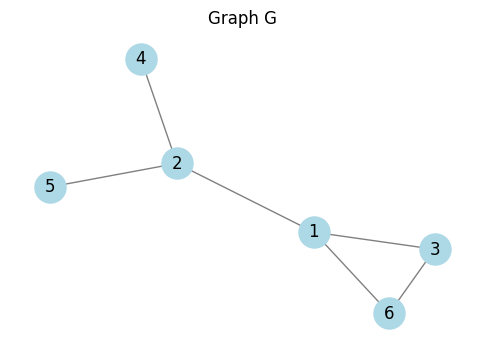

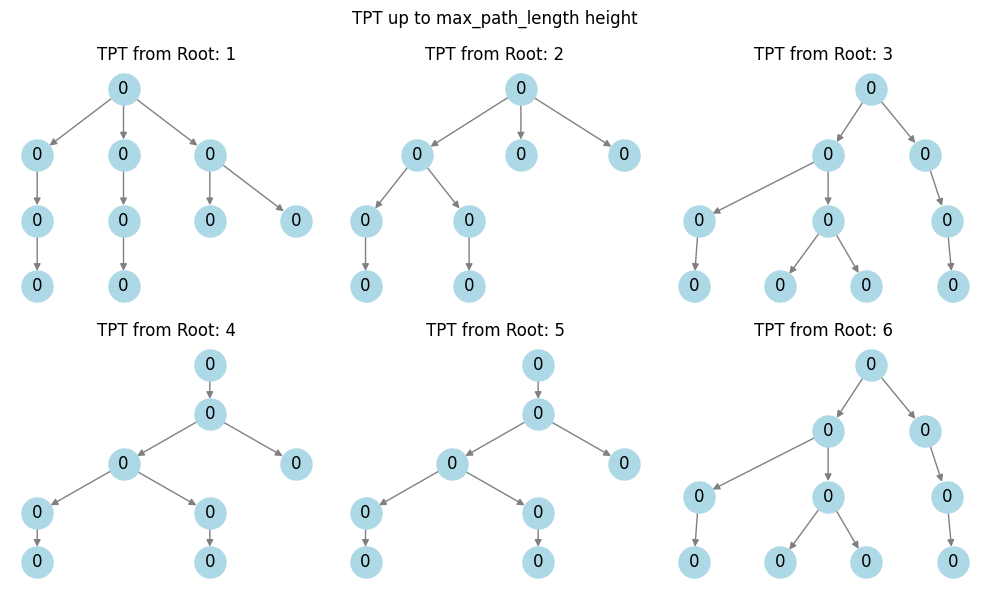

In [26]:
adjacency_list = {
    '1': ['2', '3', '6'],
    '2': ['1', '4', '5'],
    '3': ['1', '6'],
    '4': ['2'],
    '5': ['2'],
    '6': ['3']
}

possible_roots = ['1', '2', '3', '4', '5', '6']

G = Graph(adjacency_list)
G.adjacency_list = G.two_direction_adj_list()

# Plotting the graph G
fig, ax = plt.subplots(figsize=(6, 4))
G_nx = nx.Graph(G.adjacency_list)
nx.draw(G_nx, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, ax=ax)
ax.set_title("Graph G")
plt.show()

# Plotting the TPT
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle(f'TPT up to max_path_length height')

for i in range(2):
    for j in range(3):
        root = possible_roots[i * 3 + j]
        tpt = TPT(G, root)
        for node in tpt.tpt_tree.nodes():
            # Treat all nodes as having the same label '0'
            tpt.node_labels[node] = {'name': '0'}
        tpt.plot_tree_with_ax(axes[i, j])

plt.tight_layout()
plt.show()
